# Import and Libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
current_dir = "/gdrive/My Drive/ANN-2ndChallenge"

%cd $current_dir

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1u1TRupsAwXrbLPHfTcn7ROJ-D_KQsIwK/ANN-2ndChallenge


In [ ]:
!pip install torchview
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph
import gc
gc.collect()

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from sklearn.preprocessing import LabelEncoder

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

f1_average = 'macro'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cpu
Device: cpu


# Hyperparameters

In [ ]:
# Number of training epochs
LEARNING_RATE = 1e-4
EPOCHS = 1000
PATIENCE = 70

# Regularisation
DROPOUT_RATE = 0.3         # Dropout probability
L1_LAMBDA = 1e-4              # L1 penalty
L2_LAMBDA = 1e-4             # L2 penalty
SCHED_TEMP = 70

BATCH_SIZE = 8
VAL_SPLIT = 0.15

DATASET_NAME = "clean_mask_patch_cropped"
drive_zip_path = f"/gdrive/My Drive/ANN-2ndChallenge/dataset/{DATASET_NAME}.zip"


# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

experiment_name = f"BN_Norm_baseline_LR{LEARNING_RATE}_EPOCHS{EPOCHS}_PAT{PATIENCE}_DROP{DROPOUT_RATE}_L1{L1_LAMBDA}_L2{L2_LAMBDA}_BS{BATCH_SIZE}_MASKS"
print(f"Experiment name {experiment_name}")

Epochs: 1000
Batch Size: 8
Learning Rate: 0.0001
Dropout Rate: 0.3
L1 Penalty: 0.0001
L2 Penalty: 0.0001
Experiment name BN_Norm_baseline_LR0.0001_EPOCHS1000_PAT70_DROP0.3_L10.0001_L20.0001_BS8_MASKS


In [ ]:
gc.collect()

4

# Dataset Loading

In [ ]:
# Dataset extraction
local_zip_path = "/content/tiles_double_filter_bal1.zip"
local_extract_path = "/content/dataset_unzipped"

if not os.path.exists(local_extract_path):
    print("Copy of the zipped dataset")
    shutil.copy(drive_zip_path, local_zip_path)
    print("Extraction")
    shutil.unpack_archive(local_zip_path, local_extract_path)
    print("Extraction completed!")
else:
    print("Dataset already present.")

# Set paths
BASE_PATH = os.path.join(local_extract_path, f"{DATASET_NAME}/")
TRAIN_LABELS_PATH = BASE_PATH + "/train_labels.csv"
TRAIN_IMAGES_PATH = BASE_PATH + "train_data/"
TRAIN_MASKS_PATH  = BASE_PATH + "train_data/"

# Load training labels
train_labels_df = pd.read_csv(TRAIN_LABELS_PATH)

cells_images = []
masks_images = []
ids_list = []

# Load training images and masks based on labels
for idx, row in train_labels_df.iterrows():
    img_filename = row['sample_index']

    if not (img_filename.startswith('img_') and img_filename.endswith('.png')):
          continue

    img_path = os.path.join(TRAIN_IMAGES_PATH, img_filename)
    mask_filename = img_filename.replace("img", "mask")
    mask_path = os.path.join(TRAIN_MASKS_PATH, mask_filename)
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is not None and mask is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
        img = img / 255.0  # Normalize pixel values to [0, 1]
        mask = mask / 255.0  # Normalize mask values to [0, 1]

        cells_images.append(img)
        masks_images.append(mask)
        ids_list.append(img_filename)
    else:
        print(f"Warning: Could not load image or mask for {img_filename}")
        print(f"Image path: '{img_path}'")
        print(f"Mask path: '{mask_path}'")

# Convert lists to numpy arrays
X_rgb = np.array(cells_images)
X_masks = np.array(masks_images)
ids = np.array(ids_list)

if X_masks.ndim == 3:
    X_masks = np.expand_dims(X_masks, axis=-1)

print(f"Loaded {len(X_rgb)} cell images and {len(X_masks)} masks.")

Dataset already present.
Loaded 557 cell images and 557 masks.


In [ ]:
gc.collect()

0

# Dataset preprocessing

## Train-Val split

In [ ]:
# Stack RGB and masks together
X = np.concatenate((X_rgb, X_masks), axis=-1)
y = train_labels_df['label'].values

# Reshape labels to column vectors (N, 1) if they are 1D
y = y.reshape(-1, 1) if y.ndim == 1 else y

# Train-validation split
X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(
    X, y, ids, random_state=SEED, test_size=int(len(X)*VAL_SPLIT), stratify=y
)

# Print shapes of the datasets
print(f"Training Data Shape: {X_train.shape}")
print(f"Training Label Shape: {y_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Validation Label Shape: {y_val.shape}")

# Define the number of classes
num_classes = len(np.unique(y_train))
print("Number of Classes:", num_classes)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

Training Data Shape: (474, 224, 224, 4)
Training Label Shape: (474, 1)
Validation Data Shape: (83, 224, 224, 4)
Validation Label Shape: (83, 1)
Number of Classes: 4


In [ ]:
in_channels = 4

# Rearrange the dataset
if X_train.shape[-1] == in_channels:
    print("Fixing format from (N, H, W, C) to (N, C, H, W)...")
    X_train = np.transpose(X_train, (0, 3, 1, 2))
    X_val   = np.transpose(X_val,   (0, 3, 1, 2))
elif X_train.shape[1] == 224 and X_train.shape[2] == in_channels:
    print("Fixing weird format from (N, H, C, W) to (N, C, H, W)...")
    X_train = np.transpose(X_train, (0, 2, 1, 3))
    X_val   = np.transpose(X_val,   (0, 2, 1, 3))

print(f"Rearranged X_train shape: {X_train.shape}")

# Calculate class weights
class_counts = np.bincount(y_train)
total_samples = len(y_train)
num_classes = len(np.unique(y_train))

class_weights = total_samples / (num_classes * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class counts: {class_counts}")
print(f"Calculated class weights: {class_weights}")

Fixing format from (N, H, W, C) to (N, C, H, W)...
Rearranged X_train shape: (474, 4, 224, 224)
Class counts: [122 128 168  56]
Calculated class weights: tensor([0.9713, 0.9258, 0.7054, 2.1161])


## Mean & Variance

In [ ]:
# Calculate mean and std for normalization (without mask)
mean = X_train[:, :, :, :3].mean(axis=(0, 1, 2))
std = X_train[:, :, :, :3].std(axis=(0, 1, 2))

print(f"Calculated Mean: {mean}")
print(f"Calculated Std: {std}")

Calculated Mean: [0.5292606  0.52963193 0.52997223]
Calculated Std: [0.30454472 0.30397955 0.3037668 ]


## Augmentation

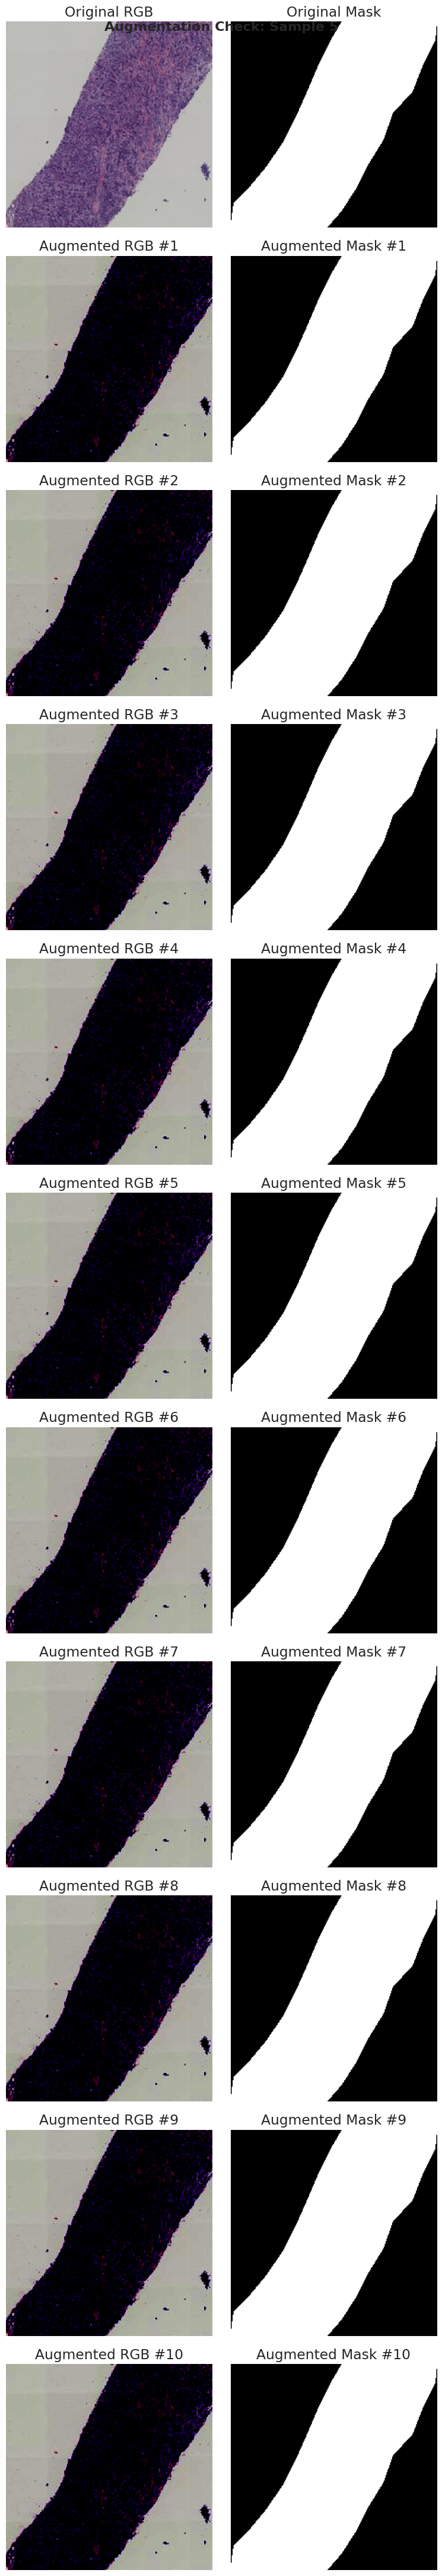

44200

In [ ]:
def visualize_augmentations(dataset, sample_idx, num_variations=3):
    """
    Visualizes the original image vs. multiple augmented versions from the dataset.

    Args:
        dataset: Your instantiated AugmentedDataset.
        sample_idx: The integer index of the image to visualize.
        num_variations: How many random augmented versions to show.
    """

    # 1. GET ORIGINAL (RAW) DATA
    raw_data = dataset.x_data[sample_idx] # Shape: (4, 224, 224)

    raw_display = np.transpose(raw_data, (1, 2, 0))
    raw_rgb = raw_display[:, :, :3]
    raw_mask = raw_display[:, :, -1]

    # 2. SETUP PLOT
    fig, axes = plt.subplots(1 + num_variations, 2, figsize=(8, 4 * (1 + num_variations)))
    plt.suptitle(f"Augmentation Check: Sample {sample_idx}", fontsize=16, fontweight='bold')

    # 3. PLOT ORIGINAL
    axes[0, 0].imshow(np.clip(raw_rgb, 0, 1))
    axes[0, 0].set_title("Original RGB")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(raw_mask, cmap='gray')
    axes[0, 1].set_title("Original Mask")
    axes[0, 1].axis('off')

    # 4. PLOT AUGMENTED VERSIONS
    for i in range(num_variations):
        # Call __getitem__ to trigger the random transforms
        aug_tensor, label = dataset[sample_idx]

        # Convert Tensor -> Numpy
        aug_np = aug_tensor.numpy()

        # Transpose (C, H, W) -> (H, W, C)
        aug_display = np.transpose(aug_np, (1, 2, 0))

        # Split Channels
        aug_rgb = aug_display[:, :, :3]
        aug_mask = aug_display[:, :, -1]

        # Plot RGB (Clip values to 0-1 range in case ColorJitter went out of bounds)
        row = i + 1
        axes[row, 0].imshow(np.clip(aug_rgb, 0, 1))
        axes[row, 0].set_title(f"Augmented RGB #{i+1}")
        axes[row, 0].axis('off')

        # Plot Mask
        axes[row, 1].imshow(aug_mask, cmap='gray')
        axes[row, 1].set_title(f"Augmented Mask #{i+1}")
        axes[row, 1].axis('off')

    plt.tight_layout()
    plt.show()

class AugmentedDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for pre-transposed (Channel-First) data.
    Input shape expectation: (N, 4, 224, 224)
    """
    def __init__(self, x_data, y_data, transform=None, mean=0, std=1):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform
        self.normalize = v2.Normalize(mean=mean, std=std)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        # 1. Get the image (Shape: 4, 224, 224)
        img_np = self.x_data[idx]
        label = self.y_data[idx]

        # 2. Convert directly to Tensor
        img_tensor = torch.from_numpy(img_np).float()

        # 3. Apply Transforms
        if self.transform:
            img_tensor = self.transform(img_tensor)

        # 4. Always normalize
        rgb = img_tensor[:3, :, :]
        mask = img_tensor[3:, :, :]
        rgb = self.normalize(rgb)
        img_tensor = torch.cat([rgb, mask], dim=0)

        return img_tensor, torch.tensor(label, dtype=torch.long)

# Define augmentations
train_augmentation = v2.Compose([
    v2.RandomErasing(p=0.05, scale=(0.01, 0.1), ratio=(1.5, 3.0), value=0.0),
    v2.RandomErasing(p=0.05, scale=(0.01, 0.1), ratio=(1/3.0, 1/1.5), value=0.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.9, 1.1)),
])

# Build augmented datasets
train_aug_ds = AugmentedDataset(X_train, y_train, transform=None, mean=mean, std=std)
val_aug_ds   = AugmentedDataset(X_val, y_val, mean=mean, std=std)

visualize_augmentations(train_aug_ds, sample_idx=5, num_variations=10)
gc.collect()

## Data Loaders

In [ ]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [ ]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_aug_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_aug_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
gc.collect()

51

# Model Training

## Model class

### Baseline CNN and SE blocks

In [ ]:
class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block for channel-wise feature re-calibration.
    """
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)   # Squeeze: Global Average Pooling
        y = self.fc(y).view(b, c, 1, 1)   # Excitation: Learn channel weights
        return x * y.expand_as(x)         # Scale: Re-calibrate channels

In [82]:
class BaselineCNN(nn.Module):

    def __init__(self, input_shape=(3, 224, 224), num_classes=2, dropout_rate=0.2):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_shape[0], 16, kernel_size=5, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #SEBlock(16),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #SEBlock(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #SEBlock(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.conv_block4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #SEBlock(64)
        )

        self.classifier_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global Average Pooling
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.classifier_head(x)
        return x

### ResNet

In [91]:
class Resnet18TransferLearning(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True, unfreeze_last_n=0):
        super().__init__()

        # 1. Load weights
        self.backbone = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

        # 2. Freeze Backbone
        if freeze_backbone:
            # Freeze everything initially
            for param in self.backbone.parameters():
                param.requires_grad = False

            # Unfreeze the last N layers
            if unfreeze_last_n > 0:
                print(f"Unfreezing last {unfreeze_last_n} parts of the backbone")

                all_layers = list(self.backbone.children())[:-1]

                for layer in all_layers[-unfreeze_last_n:]:
                    for param in layer.parameters():
                        param.requires_grad = True

        # 3. Replace Classifier
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

### EfficientNet

In [89]:
class EfficientNetB0TransferLearning(nn.Module):
    """EfficientNet-B0 with ImageNet pretrained weights."""

    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True, unfreeze_last_n=0):
        super().__init__()

        # 1. Load weights
        self.backbone = torchvision.models.efficientnet_b0(
            weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
        )

        # 2. Freeze backbone
        if freeze_backbone:
            # Freeze everything initially
            for param in self.backbone.features.parameters():
                param.requires_grad = False

            # Unfreeze the last N layers
            if unfreeze_last_n > 0:
                print(f"Unfreezing last {unfreeze_last_n} layers")
                for p in self.backbone.features[-unfreeze_last_n:]:
                    p.requires_grad = True

        # 3. Replace Classifier
        in_features = self.backbone.classifier[-1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

## Train functions definitions

In [ ]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average=f1_average
    )

    return epoch_loss, epoch_f1

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average=f1_average
    )

    return epoch_loss, epoch_accuracy

In [ ]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [ ]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler,
        device, l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1",
        mode='max', restore_best_weights=True, writer=None, verbose=10,
        experiment_name="", scheduler=None):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler (default: None)

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Update the learning rate scheduler if provided
        if scheduler is not None:
            scheduler.step()

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [88]:
import copy
import torch.optim as optim

def train_finetune_resnet(steps, model):
    '''
    Fine-tune a pre-trained ResNet model for image classification.
    Args:
        steps (int): Number of fine-tuning steps.
        model (nn.Module): Pre-trained ResNet model.
    '''

    models = []
    performances = []
    best_model = None
    best_performance = 0.0

    # Define the specific blocks in ResNet we want to unfreeze progressively
    resnet_blocks = [
        model.backbone.conv1,
        model.backbone.layer1,
        model.backbone.layer2,
        model.backbone.layer3,
        model.backbone.layer4
    ]

    for i in range(steps):
        print(f"Training step {i}")
        logs_dir = "logs"
        writer = SummaryWriter("./"+logs_dir+"/"+experiment_name+str(i))

        # Restoring best model from previous step
        if best_model is not None:
            model = copy.deepcopy(best_model)

        # Unfreeze logic for ResNet
        if i > 0:
            blocks_to_unfreeze = resnet_blocks[-i:]

            print(f"Unfreezing {len(blocks_to_unfreeze)} backbone blocks...")
            for block in blocks_to_unfreeze:
                for param in block.parameters():
                    param.requires_grad = True
        else:
            print("Step 0: Training Head Only (Backbone Frozen)")

        # Re-initialize optimizer
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adjust LR/Optimizer as needed

        # Fit
        model, history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=EPOCHS,
            criterion=criterion,
            optimizer=optimizer,
            scaler=scaler,
            device=device,
            writer=writer,
            verbose=1,
            experiment_name=experiment_name+str(i),
            patience=PATIENCE,
            l1_lambda=L1_LAMBDA,
            l2_lambda=L2_LAMBDA
        )

        # Update best model
        f1 = max(history['val_f1'])
        if f1 > best_performance:
            print(f"New best model found: {f1} > {best_performance}")
            best_model = copy.deepcopy(model)
            best_performance = f1

        models.append(copy.deepcopy(model))
        performances.append(max(history['val_f1']))

        final_val_f1 = round(max(history['val_f1']) * 100, 2)
        print(f'Final validation F1 score: {final_val_f1}%')

    return (best_model, models, performances)

In [87]:
import copy

def train_finetune_effnet(steps, model):
    '''
    Fine-tune a pre-trained EfficientNet model for image classification.
    Args:
        steps (int): Number of fine-tuning steps.
        model (nn.Module): Pre-trained EfficientNet model
    '''

    models = []
    performances = []
    best_model = None
    best_performance = 0.0

    for i in range(steps):
        print(f"Trainig step {i}")
        logs_dir = "logs"
        writer = SummaryWriter("./"+logs_dir+"/"+experiment_name+str(i))
        writer.add_graph(model, x)

        # Restoring best model from previous step
        if best_model is not None:
            model = copy.deepcopy(best_model)

        # Unfreeze logic for EfficientNet
        if i > 0:
            for p in model.backbone.features[-i:]:
                p.requires_grad = True

        # Re-initialize optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # Fit
        model, history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=EPOCHS,
            criterion=criterion,
            optimizer=optimizer,
            scaler=scaler,
            device=device,
            writer=writer,
            verbose=1,
            experiment_name=experiment_name+str(i),
            patience=PATIENCE,
            l1_lambda=L1_LAMBDA,
            freeze_batch_norm=True
        )

        # Update best model
        f1 = max(history['val_f1'])
        if  f1 > best_performance:
            print(f"New best models, {f1} > {best_performance}")
            best_model = copy.deepcopy(model)
            best_performance = f1

        models.append(model)
        performances.append(max(history['val_f1']))

        final_val_f1 = round(max(history['val_f1']) * 100, 2)
        print(f'Final validation F1 score: {final_val_f1}%')

    return (best_model, models, performances)

In [ ]:
input_shape = X_train[0].shape

# Instantiate CNN model and move to computing device (CPU/GPU)
model = BaselineCNN(
    input_shape,
    num_classes,
    dropout_rate=DROPOUT_RATE
).to(device)

# Display model architecture summary
summary(model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
x = torch.randn(1, input_shape[0], input_shape[1], input_shape[2]).to(device)

# Set up optimizer, scheduler, criterion and scaler for the model
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=SCHED_TEMP)
criterion = nn.CrossEntropyLoss(weight=class_weights)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]           1,616
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          36,928
      BatchNorm2d-14           [-1, 64,

## Train

In [ ]:
%%time
logs_dir = "logs"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
writer.add_graph(model, x)

# Train model and track training history
model, history = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name=experiment_name,
    patience=PATIENCE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA
)


Training 1000 epochs...
Epoch   1/1000 | Train: Loss=1.6190, F1 Score=0.1954 | Val: Loss=1.3957, F1 Score=0.2419
Epoch   2/1000 | Train: Loss=1.5979, F1 Score=0.2232 | Val: Loss=1.3792, F1 Score=0.2067
Epoch   3/1000 | Train: Loss=1.5944, F1 Score=0.2358 | Val: Loss=1.3792, F1 Score=0.1974
Epoch   4/1000 | Train: Loss=1.6021, F1 Score=0.2711 | Val: Loss=1.3645, F1 Score=0.2286
Epoch   5/1000 | Train: Loss=1.5874, F1 Score=0.2604 | Val: Loss=1.3500, F1 Score=0.2650
Epoch   6/1000 | Train: Loss=1.5690, F1 Score=0.2925 | Val: Loss=1.3544, F1 Score=0.2989
Epoch   7/1000 | Train: Loss=1.5725, F1 Score=0.2856 | Val: Loss=1.3441, F1 Score=0.3276
Epoch   8/1000 | Train: Loss=1.5725, F1 Score=0.2797 | Val: Loss=1.3371, F1 Score=0.3895
Epoch   9/1000 | Train: Loss=1.5841, F1 Score=0.2926 | Val: Loss=1.3382, F1 Score=0.3601
Epoch  10/1000 | Train: Loss=1.5618, F1 Score=0.3000 | Val: Loss=1.3643, F1 Score=0.2560
Epoch  11/1000 | Train: Loss=1.5742, F1 Score=0.3121 | Val: Loss=1.3437, F1 Score=0.30

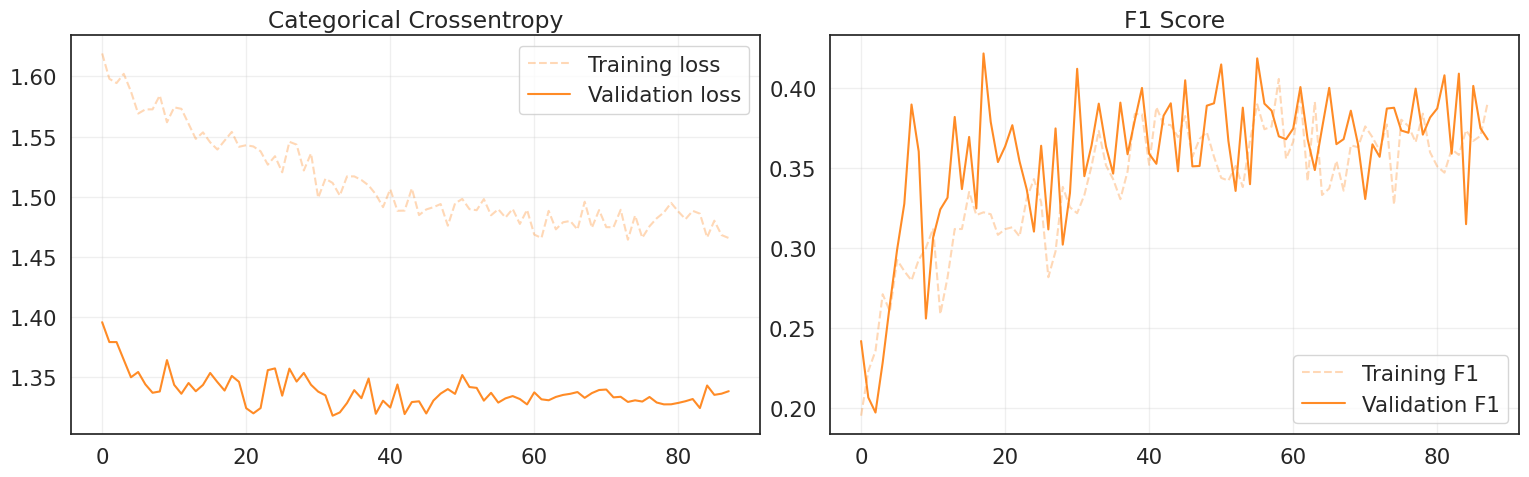

In [ ]:
# @title Plot History
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation F1 score on the second axis
ax2.plot(history['train_f1'], label='Training F1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(history['val_f1'], label='Validation F1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy:  0.4458
Precision: 0.4463
Recall:    0.4147
F1 Score:  0.4213


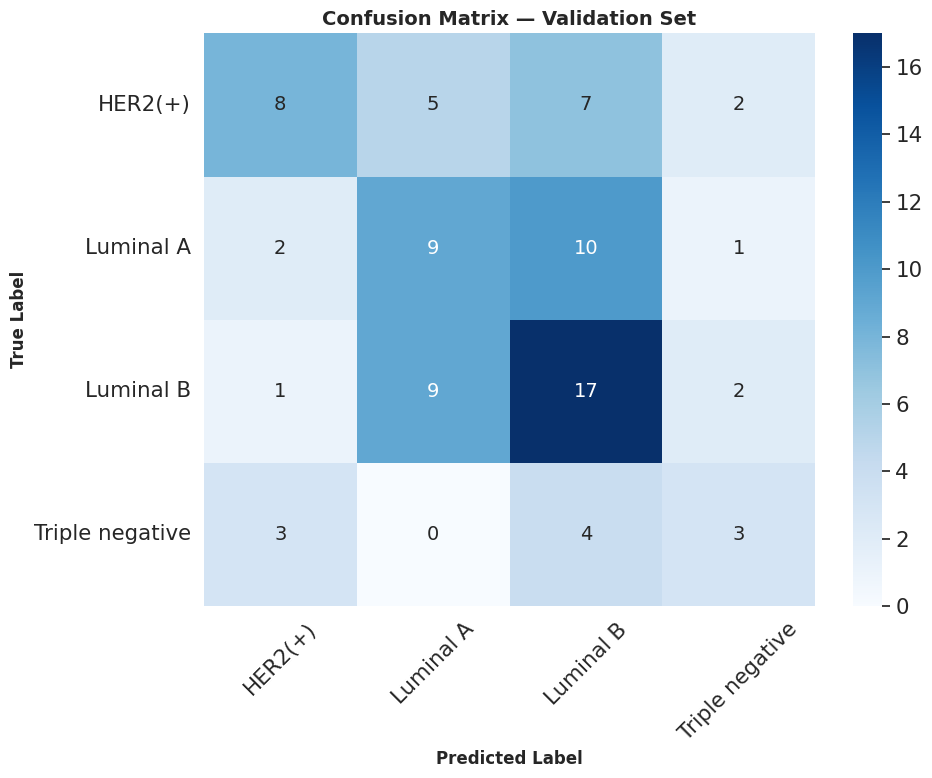

In [ ]:
# @title Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine into single numpy arrays (Integers: 0, 1, 2...)
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# 2. CALCULATE METRICS (Using Integers is safer/faster)
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average=f1_average)
val_rec = recall_score(val_targets, val_preds, average=f1_average)
val_f1 = f1_score(val_targets, val_preds, average=f1_average)

print(f"Accuracy:  {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall:    {val_rec:.4f}")
print(f"F1 Score:  {val_f1:.4f}")

# 3. CONFUSION MATRIX
# We calculate it using integers, but we LABEL it using strings
cm = confusion_matrix(val_targets, val_preds)

plt.figure(figsize=(10, 8))

# FIX B: Use le.classes_ to show String Labels on the axes
sns.heatmap(
    cm,
    annot=True,      # Show numbers inside boxes
    fmt='d',         # Integers (not 1.2e+02)
    cmap='Blues',
    xticklabels=le.classes_, # <--- THIS PUTS THE STRING LABELS
    yticklabels=le.classes_  # <--- THIS PUTS THE STRING LABELS
)

plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix — Validation Set', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### GRAD-Cam

Looking up 10 images...


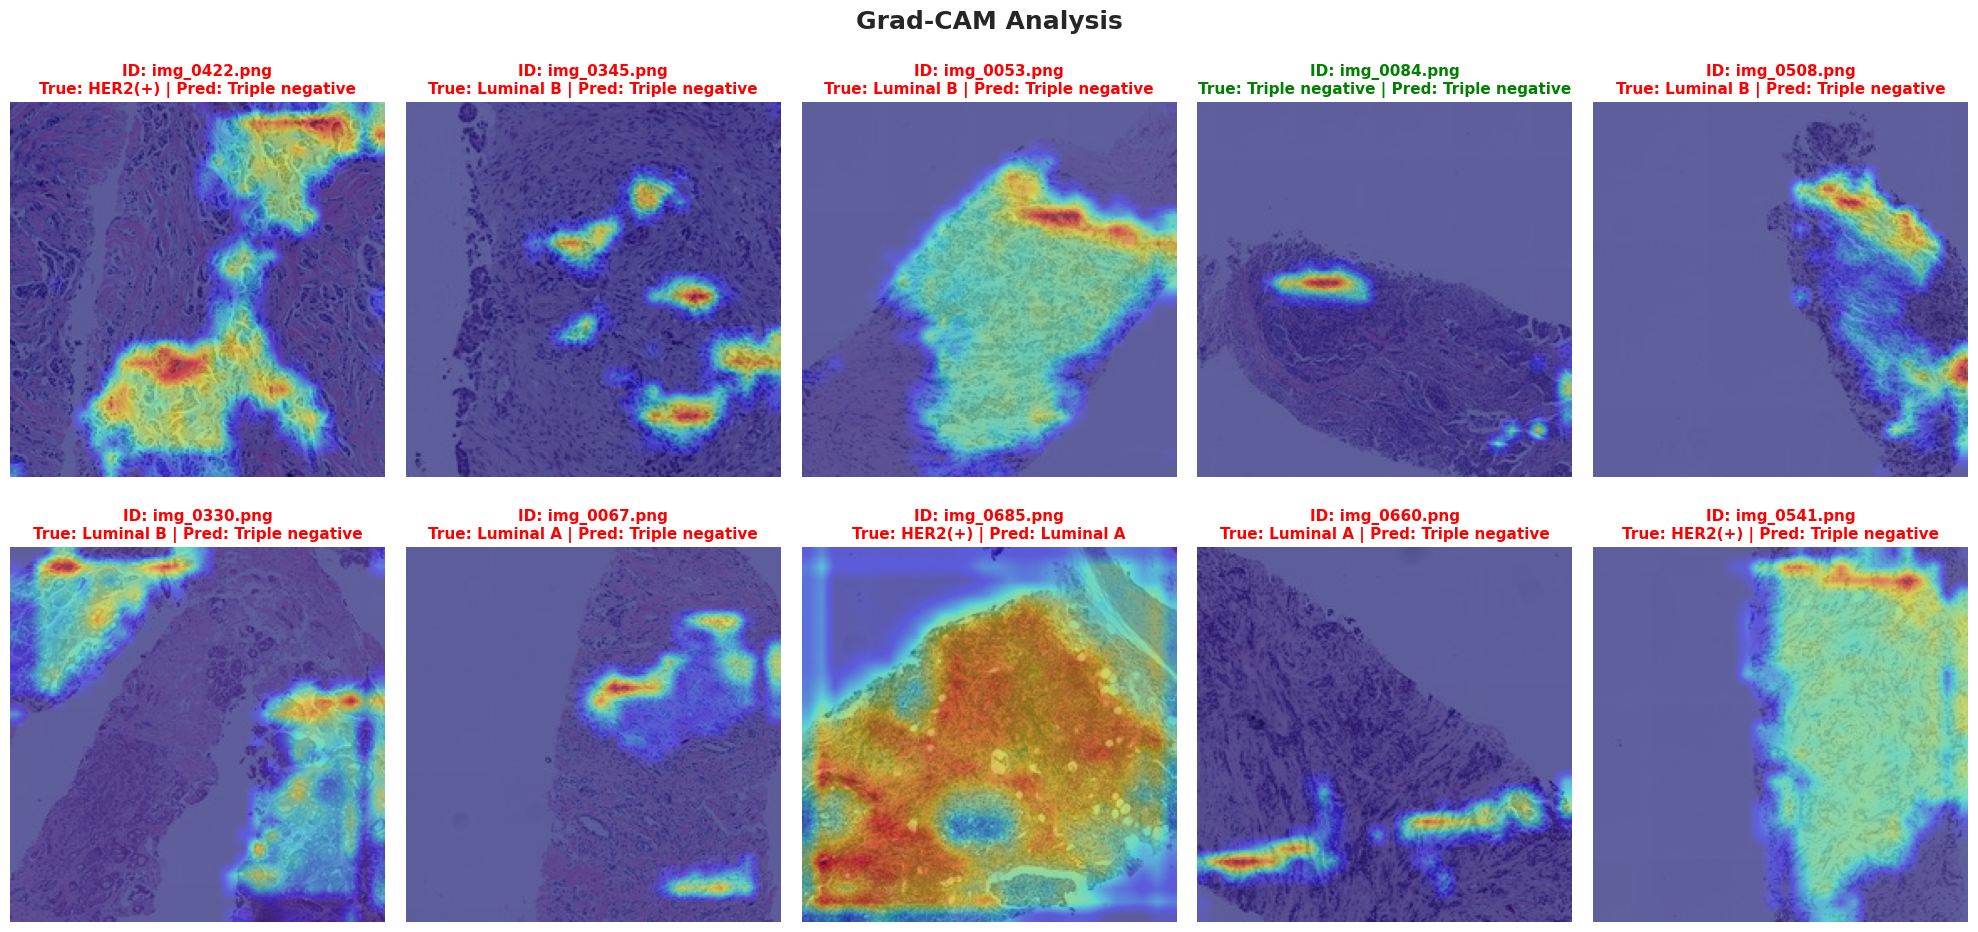

In [ ]:
import math

# --- 1. KEEP THE GRAD-CAM CLASS DEFINITION ---
class GradCAM:
    """Grad-CAM implementation."""
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        self.handles = []
        self.handles.append(target_layer.register_forward_hook(self.save_activation))
        self.handles.append(target_layer.register_full_backward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def cleanup(self):
        for h in self.handles:
            h.remove()

    def __call__(self, x, class_idx=None):
        self.model.eval()
        self.model.zero_grad()
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        output[0, class_idx].backward()

        grads = self.gradients.cpu().numpy()[0]
        acts = self.activations.detach().cpu().numpy()[0]
        weights = np.mean(grads, axis=(1, 2))

        cam = np.zeros(acts.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * acts[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (x.shape[3], x.shape[2]))
        return cam / (cam.max() + 1e-8), class_idx

def visualize_gradcam(model, target_layer, images_numpy, all_sample_ids, target_filenames, label_encoder, device, true_labels=None):
    """
    Args:
        model: Trained PyTorch model.
        target_layer: Specific layer (e.g. model.conv3).
        images_numpy: Full validation dataset (N, C, H, W).
        all_sample_ids: Full list of IDs corresponding to images_numpy (e.g. ids_val).
        target_filenames: List of specific strings you want to plot (e.g. ['img_001.png', ...]).
        label_encoder: Fitted LabelEncoder.
        device: 'cuda' or 'cpu'.
        true_labels: (Optional) Full list of True labels corresponding to images_numpy.
    """
    print(f"Looking up {len(target_filenames)} images...")

    # 1. Create a lookup dictionary: Map 'img_001.png' -> Index 0
    # This allows us to find the correct image in the numpy array instantly
    filename_to_idx = {name: i for i, name in enumerate(all_sample_ids)}

    # Filter out filenames that might not exist in the validation set
    valid_requests = []
    for name in target_filenames:
        if name in filename_to_idx:
            valid_requests.append(name)
        else:
            print(f"⚠️ Warning: '{name}' not found in the provided dataset ID list.")

    if not valid_requests:
        print("No valid images found to plot.")
        return

    # Initialize Grad-CAM
    gcam = GradCAM(model, target_layer)
    model.eval()

    # Calculate Grid
    num_images = len(valid_requests)
    cols = 5
    rows = math.ceil(num_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    plt.suptitle("Grad-CAM Analysis", fontsize=18, fontweight='bold')

    if num_images > 1: axes = axes.flatten()
    else: axes = [axes]

    # Loop through the specific filenames requested
    for i, filename in enumerate(valid_requests):
        ax = axes[i]

        # Retrieve the integer index for this filename
        idx = filename_to_idx[filename]

        # A. Prepare Tensor
        img_np = images_numpy[idx]
        img_tensor = torch.tensor(img_np).unsqueeze(0).float().to(device)
        img_tensor.requires_grad = True

        # B. Generate Heatmap
        mask, pred_idx = gcam(img_tensor)

        # C. Decode Strings
        pred_str = label_encoder.inverse_transform([pred_idx])[0]

        # D. Construct Title
        title_lines = [f"ID: {filename}"] # Show the string ID

        if true_labels is not None:
            true_idx = int(true_labels[idx])
            true_str = label_encoder.inverse_transform([true_idx])[0]
            color = 'green' if true_idx == pred_idx else 'red'
            title_lines.append(f"True: {true_str} | Pred: {pred_str}")
        else:
            color = 'black'
            title_lines.append(f"Pred: {pred_str}")

        title_text = "\n".join(title_lines)

        # E. Display
        img_display = np.transpose(img_np, (1, 2, 0))
        img_rgb = img_display[:, :, :3]

        ax.imshow(img_rgb)
        ax.imshow(mask, cmap='jet', alpha=0.5)
        ax.set_title(title_text, fontsize=11, fontweight='bold', color=color)
        ax.axis('off')

    # Hide empty subplots
    for j in range(i + 1, len(axes)): axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    gcam.cleanup()

# 1. Define the specific images you want to see
# OR just take the first 10 names from ids_val programmatically
specific_images = ids_val[:10]

# 2. Call the function with X_val and ids_val
visualize_gradcam(
    model=model,
    target_layer=model.conv_block4[0], # Corrected to access the Conv2d layer within conv_block4
    images_numpy=X_val,      # Use X_val which is (N, C, H, W)
    all_sample_ids=ids_val,  # Use ids_val to match X_val order
    target_filenames=specific_images,
    label_encoder=le,
    device=device,
    true_labels=y_val        # Use y_val which is already integer-encoded
)

In [ ]:
gc.collect()

27900

# Test

Loading test data...
Fixing format from (N, H, W, C) to (N, C, H, W)...
Final Test Data Shape: (477, 4, 224, 224)
Prepare dataloader...
Running inference...
Decoding and saving CSV...
Submission saved to submissions/BN_Norm_baseline_LR0.0001_EPOCHS1000_PAT70_DROP0.3_L10.0001_L20.0001_BS8_MASKS.csv


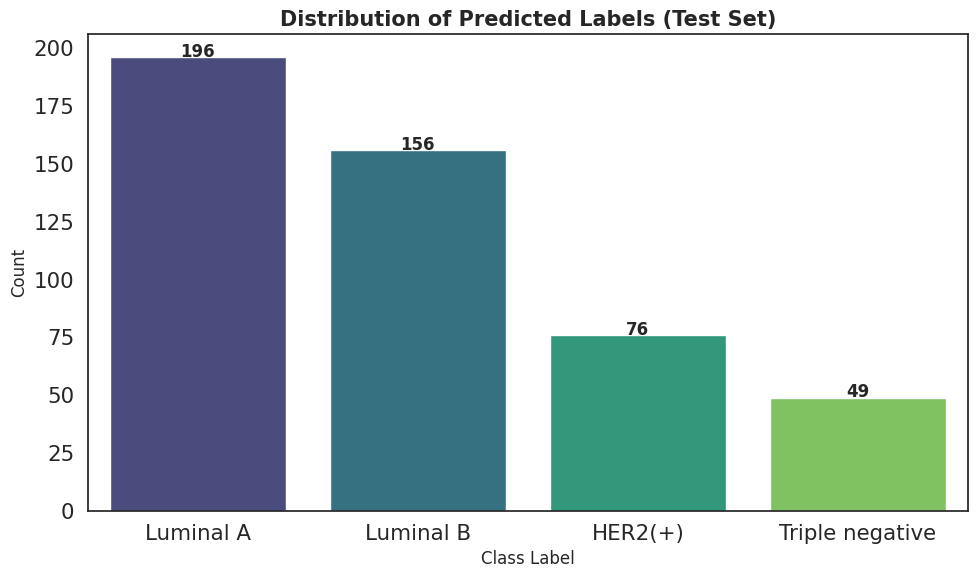


Predicted Counts:
label
Luminal A          196
Luminal B          156
HER2(+)             76
Triple negative     49
Name: count, dtype: int64


In [ ]:
TEST_IMAGES_PATH = BASE_PATH + "test_data/"
TEST_MASKS_PATH = BASE_PATH + "test_data/"

test_imgs = []
test_masks = []
test_ids = []

# 1. LOAD DATA FROM EXTRACTED FOLDER
print("Loading test data...")

for img_filename in os.listdir(TEST_IMAGES_PATH):

    if not (img_filename.startswith('img_') and img_filename.endswith('.png')):
      continue  # Skip masks

    # Read image and mask
    img_path = TEST_IMAGES_PATH + img_filename
    mask_path = TEST_MASKS_PATH + img_filename.replace("img", "mask")
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Scaling and appending the image
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
        img = img / 255.0  # Normalize pixel values to [0, 1]
        mask = mask / 255.0

        test_imgs.append(img)
        test_masks.append(mask)
        test_ids.append(img_filename)
    else:
        print(f"Warning: Could not load image or mask for {img_filename}")
        print(f"Image path: '{img_path}'")

# Convert images to np arrays
images = np.array(test_imgs)
masks = np.array(test_masks)
ids = np.array(test_ids)

if masks.ndim == 3:
    masks = np.expand_dims(masks, axis=-1)

# Stack masks on the fourth channel
X = np.concatenate((images, masks), axis=-1)

# Rearrange the dataset shape
in_channels = 4
if X.shape[-1] == in_channels:
    print("Fixing format from (N, H, W, C) to (N, C, H, W)...")
    X = np.transpose(X, (0, 3, 1, 2))
elif X.shape[1] == 224 and X.shape[2] == in_channels:
    print("Fixing weird format from (N, H, C, W) to (N, C, H, W)...")
    X = np.transpose(X, (0, 2, 1, 3))

print(f"Final Test Data Shape: {X.shape}")


# 2. PREPARE DATALOADER
print("Prepare dataloader...")

test_tensor = torch.from_numpy(X).float()
transformed_list = []

for i in range(len(test_tensor)):
    # Separate RGB and mask channels
    rgb_channels = test_tensor[i, :3, :, :] # (3, 224, 224)
    mask_channel = test_tensor[i, 3:, :, :] # (1, 224, 224)

    # Normalize RGB channels using the validation augmentation dataset's normalize transform
    normalized_rgb = val_aug_ds.normalize(rgb_channels)

    # Concatenate the normalized RGB channels with the mask channel
    combined_tensor = torch.cat([normalized_rgb, mask_channel], dim=0)
    transformed_list.append(combined_tensor)

test_tensor = torch.stack(transformed_list)

test_ds = TensorDataset(test_tensor)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


# 3. RUN INFERENCE
print("Running inference...")

model.eval() # Set model to evaluation mode
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)

        logits = model(inputs)

        preds = torch.nn.functional.softmax(logits, dim=1)
        all_probs.extend(preds.cpu().numpy())

all_probs = np.array(all_probs)
df = pd.DataFrame(all_probs)
df['tile_name'] = ids

def get_base_id(filename):
    return "_".join(filename.split("_")[:2])

df["sample_index"] = df["tile_name"].apply(get_base_id)
aggregated = df.groupby("sample_index").max(numeric_only=True)
aggregated["pred"] = aggregated.idxmax(axis=1).astype(int)

# 4. DECODE AND SAVE CSV
print("Decoding and saving CSV...")

# Convert integer predictions (0, 1, 2) back to strings ('Luminal A', etc.)
predicted_labels = le.inverse_transform(aggregated["pred"])

# Create DataFrame
submission_df = pd.DataFrame({
    'sample_index': aggregated.index,
    'label': predicted_labels
})

# Save to CSV
csv_filename = "submissions/" + experiment_name + ".csv"
submission_df.to_csv(csv_filename, index=False)
print(f"Submission saved to {csv_filename}")


# 5. LABEL DISTRIBUTION
plt.figure(figsize=(10, 6))

label_counts = submission_df['label'].value_counts()
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')

plt.title('Distribution of Predicted Labels (Test Set)', fontsize=15, fontweight='bold')
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,
            f'{int(height)}',
            ha="center", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nPredicted Counts:")
print(label_counts)
